In [9]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_utilities.config as cfg

In [15]:
output_dir = os.path.join(cfg.results_dir, 'burden_prediction', 'single_cancer')
# output_dir = os.path.join(cfg.results_dir, 'burden_prediction_ols', 'single_cancer')
# output_dir = os.path.join(cfg.results_dir, 'burden_prediction_ols', 'pancancer')

results_dfs = []

for gene in os.listdir(output_dir):
    gene_dir = os.path.join(output_dir, gene)
    signal_results_file = os.path.join(gene_dir, 'signal_metrics.tsv.gz')
    shuffled_results_file = os.path.join(gene_dir, 'shuffled_metrics.tsv.gz')
    try:
        results_dfs.append(pd.read_csv(signal_results_file, sep='\t'))
        results_dfs.append(pd.read_csv(shuffled_results_file, sep='\t'))
    except FileNotFoundError:
        continue
    
results_df = pd.concat(results_dfs)
results_df['nlog10_mse'] = -np.log(results_df.mse)
results_df.loc[results_df['r_squared'] < -1.0, 'r_squared'] = -1.0
results_df.head()

,mse,r_squared,holdout_cancer_type,signal,seed,data_type,fold,nlog10_mse
0,1.503300e+25,-1.000000,HNSC,signal,42,train,0,-57.972290
1,6.816000e+24,-1.000000,HNSC,signal,42,test,0,-57.181315
2,1.339400e-01,-0.000279,HNSC,signal,42,train,1,2.010363
3,1.216000e-01,-0.006279,HNSC,signal,42,test,1,2.107018
4,1.586600e+25,-1.000000,HNSC,signal,42,train,2,-58.026221


In [16]:
print(np.unique(results_df['holdout_cancer_type'].values))

['ACC' 'BLCA' 'BRCA' 'CESC' 'CHOL' 'COAD' 'DLBC' 'ESCA' 'GBM' 'HNSC'
 'KICH' 'KIRC' 'KIRP' 'LAML' 'LGG' 'LIHC' 'LUAD' 'LUSC' 'MESO' 'OV' 'PAAD'
 'PCPG' 'PRAD' 'READ' 'SARC' 'SKCM' 'STAD' 'TGCT' 'THCA' 'THYM' 'UCEC'
 'UCS' 'UVM']


Text(0, 0.5, '$-\\log_{10}($MSE$)$')

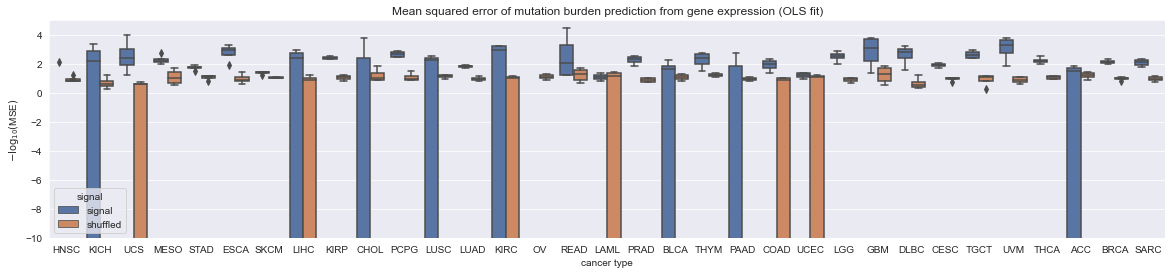

In [26]:
plot_df = results_df[results_df.data_type == 'test']
sns.set({'figure.figsize': (20, 4)})
sns.boxplot(data=plot_df, x='holdout_cancer_type', y='nlog10_mse', hue='signal')
plt.title(r'Mean squared error of mutation burden prediction from gene expression (OLS fit)')
plt.xlabel('cancer type')
plt.ylim(-10, 5)
plt.ylabel(r'$-\log_{10}($MSE$)$')

Text(0, 0.5, '$R^2$')

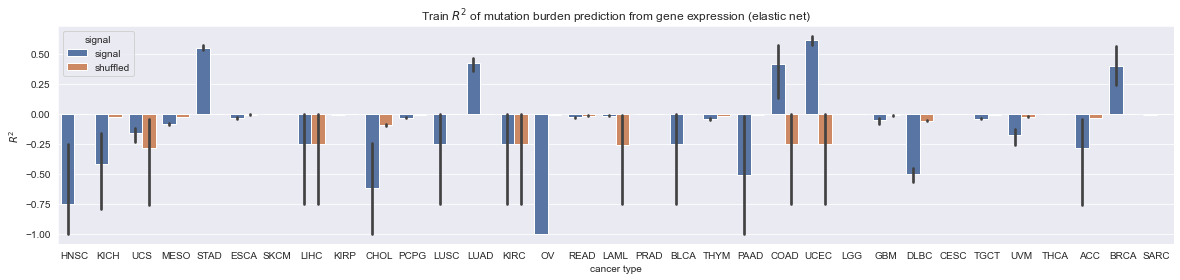

In [20]:
plot_df = results_df[results_df.data_type == 'train']
sns.set({'figure.figsize': (20, 4)})
sns.barplot(data=plot_df, x='holdout_cancer_type', y='r_squared', hue='signal')
plt.title(r'Train $R^2$ of mutation burden prediction from gene expression (elastic net)')
plt.xlabel('cancer type')
plt.ylabel(r'$R^2$')

Text(0, 0.5, '$R^2$')

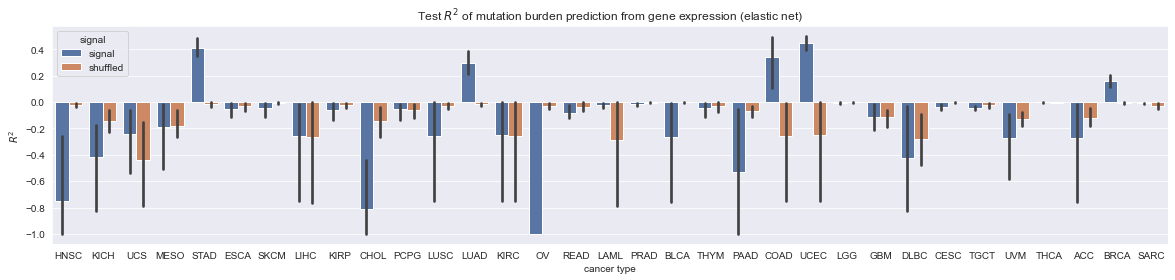

In [21]:
plot_df = results_df[results_df.data_type == 'test']
sns.set({'figure.figsize': (20, 4)})
sns.barplot(data=plot_df, x='holdout_cancer_type', y='r_squared', hue='signal')
plt.title(r'Test $R^2$ of mutation burden prediction from gene expression (elastic net)')
plt.xlabel('cancer type')
plt.ylabel(r'$R^2$')

In [22]:
# scatter plot performance vs. sample size
counts_df = pd.read_csv(os.path.join(cfg.results_dir, 'burden_prediction',
                                     'cancer_type_filtered_counts.tsv'),
                        sep='\t', index_col='cancer_type')
plot_df = results_df[(results_df.data_type == 'test') & (results_df.signal == 'signal')]
print(plot_df.shape)
plot_df = (
    plot_df.groupby(['holdout_cancer_type', 'signal']).mean()
           .reset_index()
           .drop(['seed', 'fold'], axis='columns')
)
print(plot_df.shape)
plot_df = plot_df.merge(counts_df, how='left', left_on='holdout_cancer_type', right_on='cancer_type')
print(plot_df.shape)
plot_df.head()

(132, 8)
(33, 5)
(33, 6)


,holdout_cancer_type,signal,mse,r_squared,nlog10_mse,n=
0,ACC,signal,2.206675e+24,-0.274450,-13.144089,76
1,BLCA,signal,2.495125e+24,-0.267899,-13.000478,398
2,BRCA,signal,1.187570e-01,0.160820,2.139149,981
3,CESC,signal,1.500675e-01,-0.034413,1.904143,272
4,CHOL,signal,2.303575e+24,-0.812617,-26.936167,36


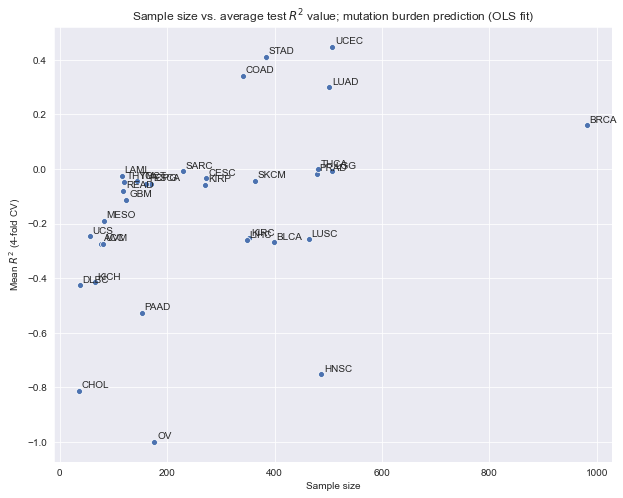

In [23]:
sns.set({'figure.figsize': (10, 8)})
sns.scatterplot(data=plot_df, x='n=', y='r_squared')
plt.title(r'Sample size vs. average test $R^2$ value; mutation burden prediction (OLS fit)')
plt.xlabel('Sample size')
plt.ylabel(r'Mean $R^2$ (4-fold CV)')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+5, point['y']+0.01, str(point['val']))

label_point(plot_df['n='], plot_df.r_squared, plot_df.holdout_cancer_type, plt.gca())  

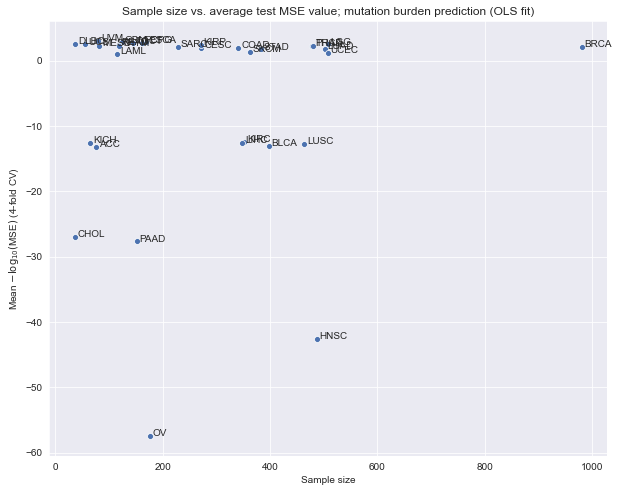

In [24]:
sns.set({'figure.figsize': (10, 8)})
sns.scatterplot(data=plot_df, x='n=', y='nlog10_mse')
plt.title(r'Sample size vs. average test MSE value; mutation burden prediction (OLS fit)')
plt.xlabel('Sample size')
plt.ylabel(r'Mean $-\log_{10}($MSE$)$ (4-fold CV)')

label_point(plot_df['n='], plot_df.nlog10_mse, plot_df.holdout_cancer_type, plt.gca())  

In [9]:
# do some coefficient analysis
pancancer_dir = os.path.join(cfg.results_dir, 'pancancer')
single_cancer_dir = os.path.join(cfg.results_dir, 'single_cancer')

In [10]:
coefs_dfs = []

for gene_name in os.listdir(single_cancer_dir):
    gene_dir = os.path.join(single_cancer_dir, gene_name)
    for coefs_file in os.listdir(gene_dir):
        if 'coefficients' not in coefs_file: continue
        full_coefs_file = os.path.join(gene_dir, coefs_file)
        gene = coefs_file.split('_')[0]
        cancer_type = coefs_file.split('_')[1]
        gene_coefs_df = pd.read_csv(full_coefs_file, sep='\t')
        gene_coefs_df = gene_coefs_df[gene_coefs_df['feature'] == 'log10_mut']
        gene_coefs_df['train_set'] = 'single_cancer'
        gene_coefs_df['cancer_type'] = cancer_type
        gene_coefs_df['is_TTN'] = 'TTN' in gene_coefs_df['gene'].values
        coefs_dfs.append(gene_coefs_df)
        
for gene_name in os.listdir(pancancer_dir):
    gene_dir = os.path.join(pancancer_dir, gene_name)
    for coefs_file in os.listdir(gene_dir):
        if 'coefficients' not in coefs_file: continue
        full_coefs_file = os.path.join(gene_dir, coefs_file)
        gene = coefs_file.split('_')[0]
        cancer_type = coefs_file.split('_')[1]
        gene_coefs_df = pd.read_csv(full_coefs_file, sep='\t')
        gene_coefs_df = gene_coefs_df[gene_coefs_df['feature'] == 'log10_mut']
        gene_coefs_df['train_set'] = 'pancancer'
        gene_coefs_df['cancer_type'] = cancer_type
        gene_coefs_df['is_TTN'] = 'TTN' in gene_coefs_df['gene'].values
        coefs_dfs.append(gene_coefs_df)

coefs_df = pd.concat(coefs_dfs)
coefs_df.head()

,feature,weight,abs,signal,seed,gene,fold,train_set,cancer_type,is_TTN
16148,log10_mut,0.000000,0.000000,shuffled,42,TP53,0,single_cancer,BRCA,False
16149,log10_mut,-0.040193,0.040193,shuffled,42,TP53,1,single_cancer,BRCA,False
48446,log10_mut,0.000000,0.000000,shuffled,42,TP53,2,single_cancer,BRCA,False
48447,log10_mut,-0.526780,0.526780,shuffled,42,TP53,3,single_cancer,BRCA,False
16148,log10_mut,0.000000,0.000000,signal,42,TP53,0,single_cancer,SARC,False


Text(0, 0.5, '$\\beta($mutation burden$)$ distribution')

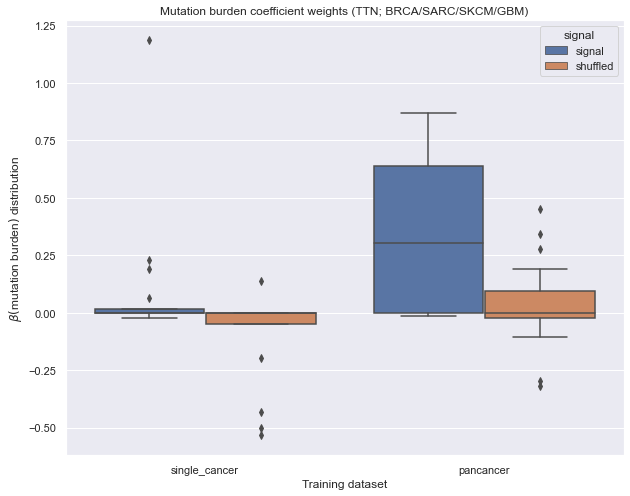

In [12]:
sns.set()
ttn_df = coefs_df[coefs_df.is_TTN]
sns.boxplot(data=ttn_df, x='train_set', y='weight', hue='signal')
plt.title('Mutation burden coefficient weights (TTN; BRCA/SARC/SKCM/GBM)')
plt.xlabel('Training dataset')
plt.ylabel(r'$\beta($mutation burden$)$ distribution')

In [35]:
# compare pancancer only results
ols_pancancer_df = pd.read_csv(
    os.path.join(cfg.results_dir, 'burden_prediction_ols', 'pancancer_only', 'signal_metrics.tsv.gz'),
    sep='\t'
)
ols_pancancer_df['model'] = 'ordinary least squares'
# ols_pancancer_shuffled_df = pd.read_csv(
#     os.path.join(cfg.results_dir, 'burden_prediction_ols', 'pancancer_only', 'shuffled_metrics.tsv.gz'),
#     sep='\t'
# )
# ols_pancancer_shuffled_df.model = 'ols'
enet_pancancer_df = pd.read_csv(
    os.path.join(cfg.results_dir, 'burden_prediction', 'pancancer_only', 'signal_metrics.tsv.gz'),
    sep='\t'
)
enet_pancancer_df['model'] = 'elastic net'
# enet_pancancer_shuffled_df = pd.read_csv(
#     os.path.join(cfg.results_dir, 'burden_prediction', 'pancancer_only', 'shuffled_metrics.tsv.gz'),
#     sep='\t'
# )
# enet_pancancer_shuffled_df.model = 'elastic_net'
# pancancer_df = pd.concat((ols_pancancer_df, ols_pancancer_shuffled_df, enet_pancancer_df, enet_pancancer_shuffled_df))
pancancer_df = pd.concat((ols_pancancer_df, enet_pancancer_df))
pancancer_df.head(n=20)

,mse,r_squared,holdout_cancer_type,signal,seed,data_type,fold,model
0,1.972600e-28,1.00000,pancancer_only,signal,42,train,0,ordinary least squares
1,1.073100e+00,-2.16370,pancancer_only,signal,42,test,0,ordinary least squares
2,1.116300e-28,1.00000,pancancer_only,signal,42,train,1,ordinary least squares
3,1.119800e+00,-2.04160,pancancer_only,signal,42,test,1,ordinary least squares
4,1.689300e-28,1.00000,pancancer_only,signal,42,train,2,ordinary least squares
5,1.216400e+00,-2.44220,pancancer_only,signal,42,test,2,ordinary least squares
6,1.986100e-28,1.00000,pancancer_only,signal,42,train,3,ordinary least squares
7,1.224800e+00,-2.47880,pancancer_only,signal,42,test,3,ordinary least squares
0,9.494400e-02,0.73155,pancancer_only,signal,42,train,0,elastic net
1,1.279400e-01,0.63623,pancancer_only,signal,42,test,0,elastic net


Text(0.5, 1.0, 'Pancancer train/test $R^2$, OLS vs. elastic net')

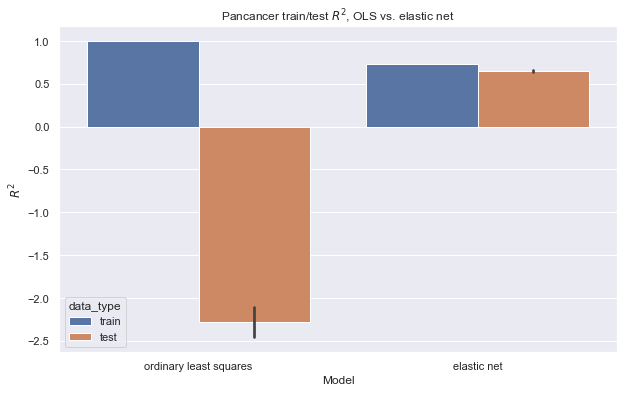

In [37]:
sns.set({'figure.figsize': (10, 6)})
# plot_df = pancancer_df[pancancer_df['data_type'] == 'test']
plot_df = pancancer_df
sns.barplot(data=plot_df, x='model', y='r_squared', hue='data_type')
plt.xlabel('Model')
plt.ylabel(r'$R^2$')
plt.title('Pancancer train/test $R^2$, OLS vs. elastic net')